### 1.Data preparation:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_h5ad('data/results/scanpy_qc_filtered_covid.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 5589 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)


# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 5589 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 3058


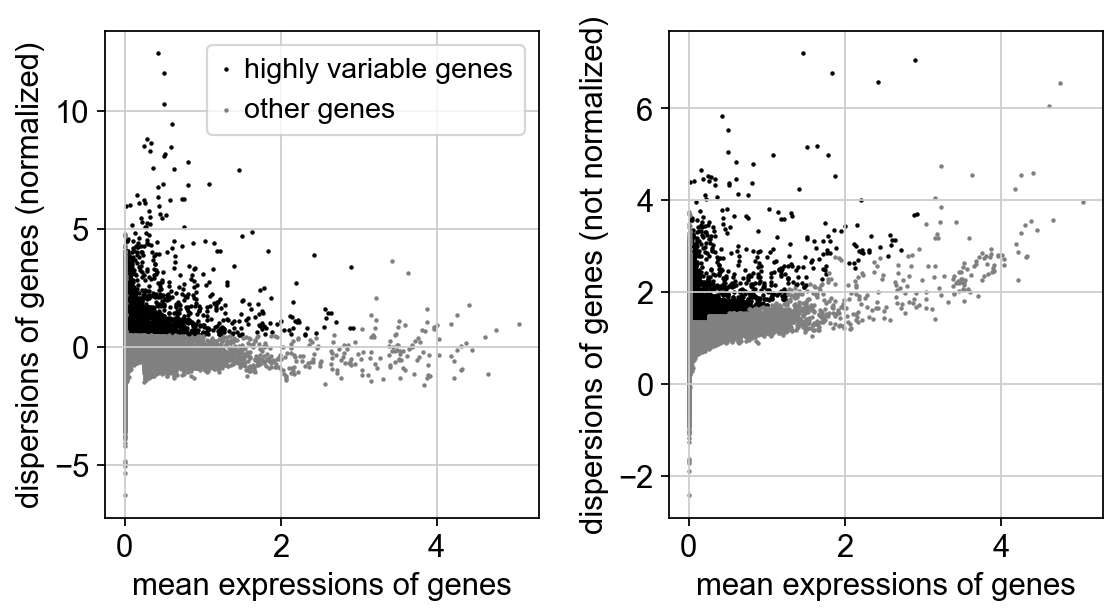

In [7]:
# compute variable genes 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

# plot variable genes
sc.pl.highly_variable_genes(adata)

#subset for variable genes in dataset
adata = adata[:, adata.var['highly_variable']]

### 1.1 Z-score transformation

In [8]:
# regress out 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale data
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:37)


### 2.PCA

In [9]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


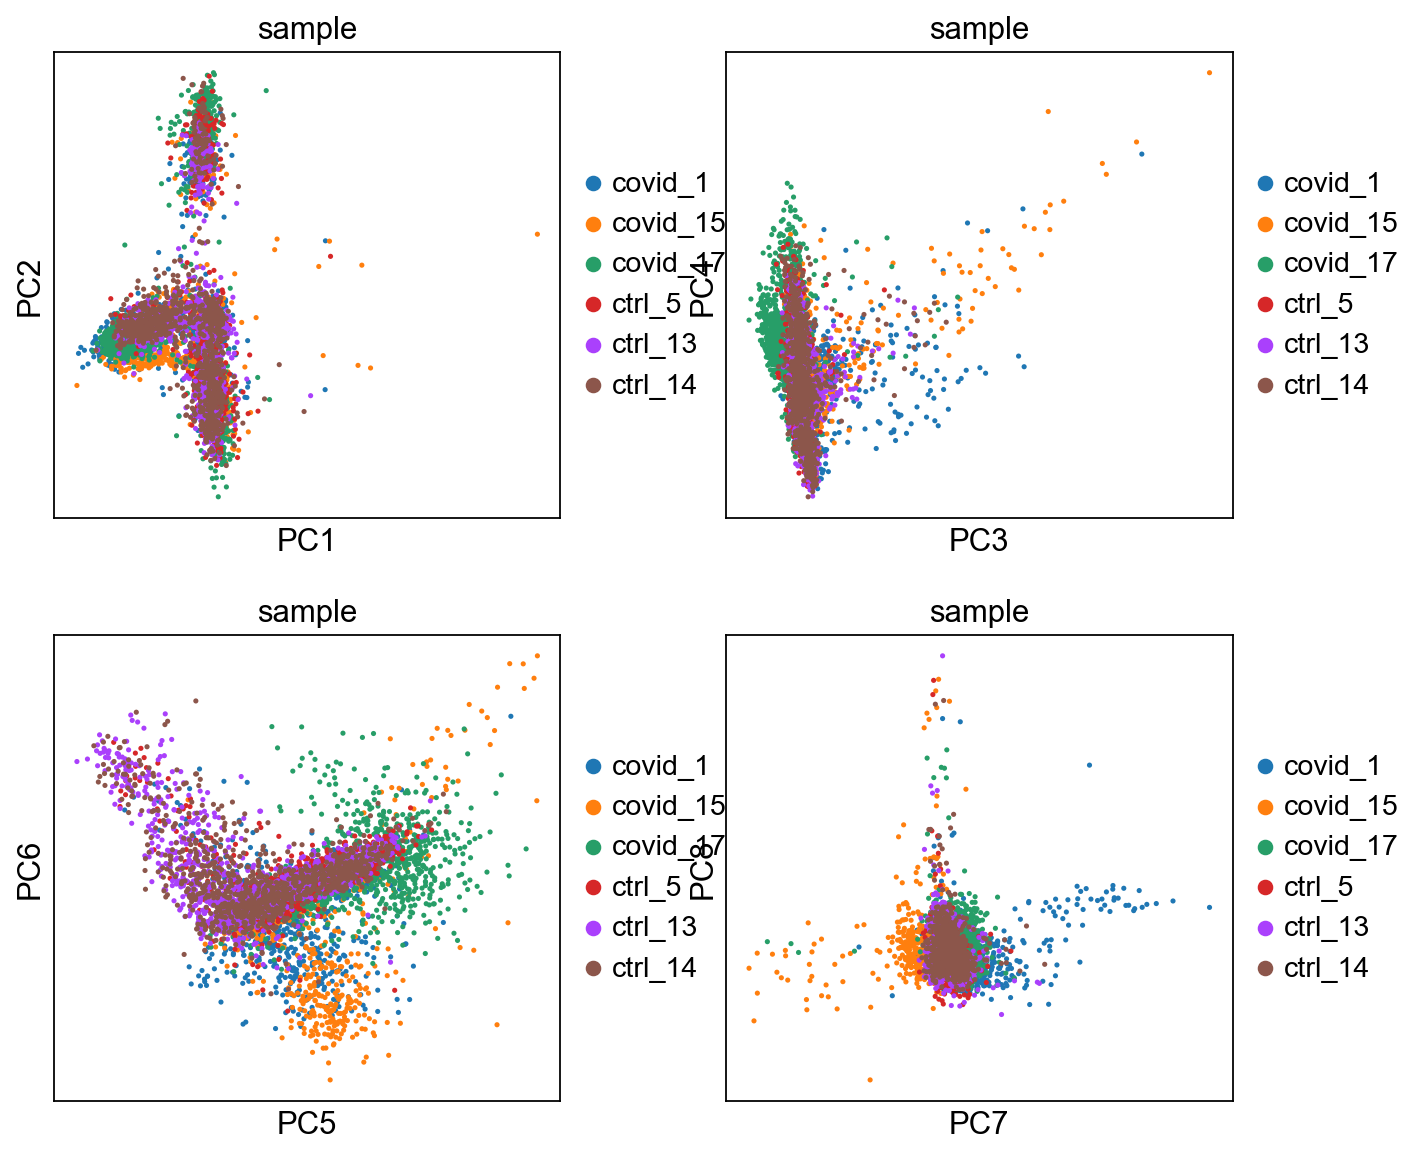

In [10]:
sc.pl.pca(adata, color='sample', components = ['1,2', '3,4', '5,6', '7,8'], ncols=2)

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


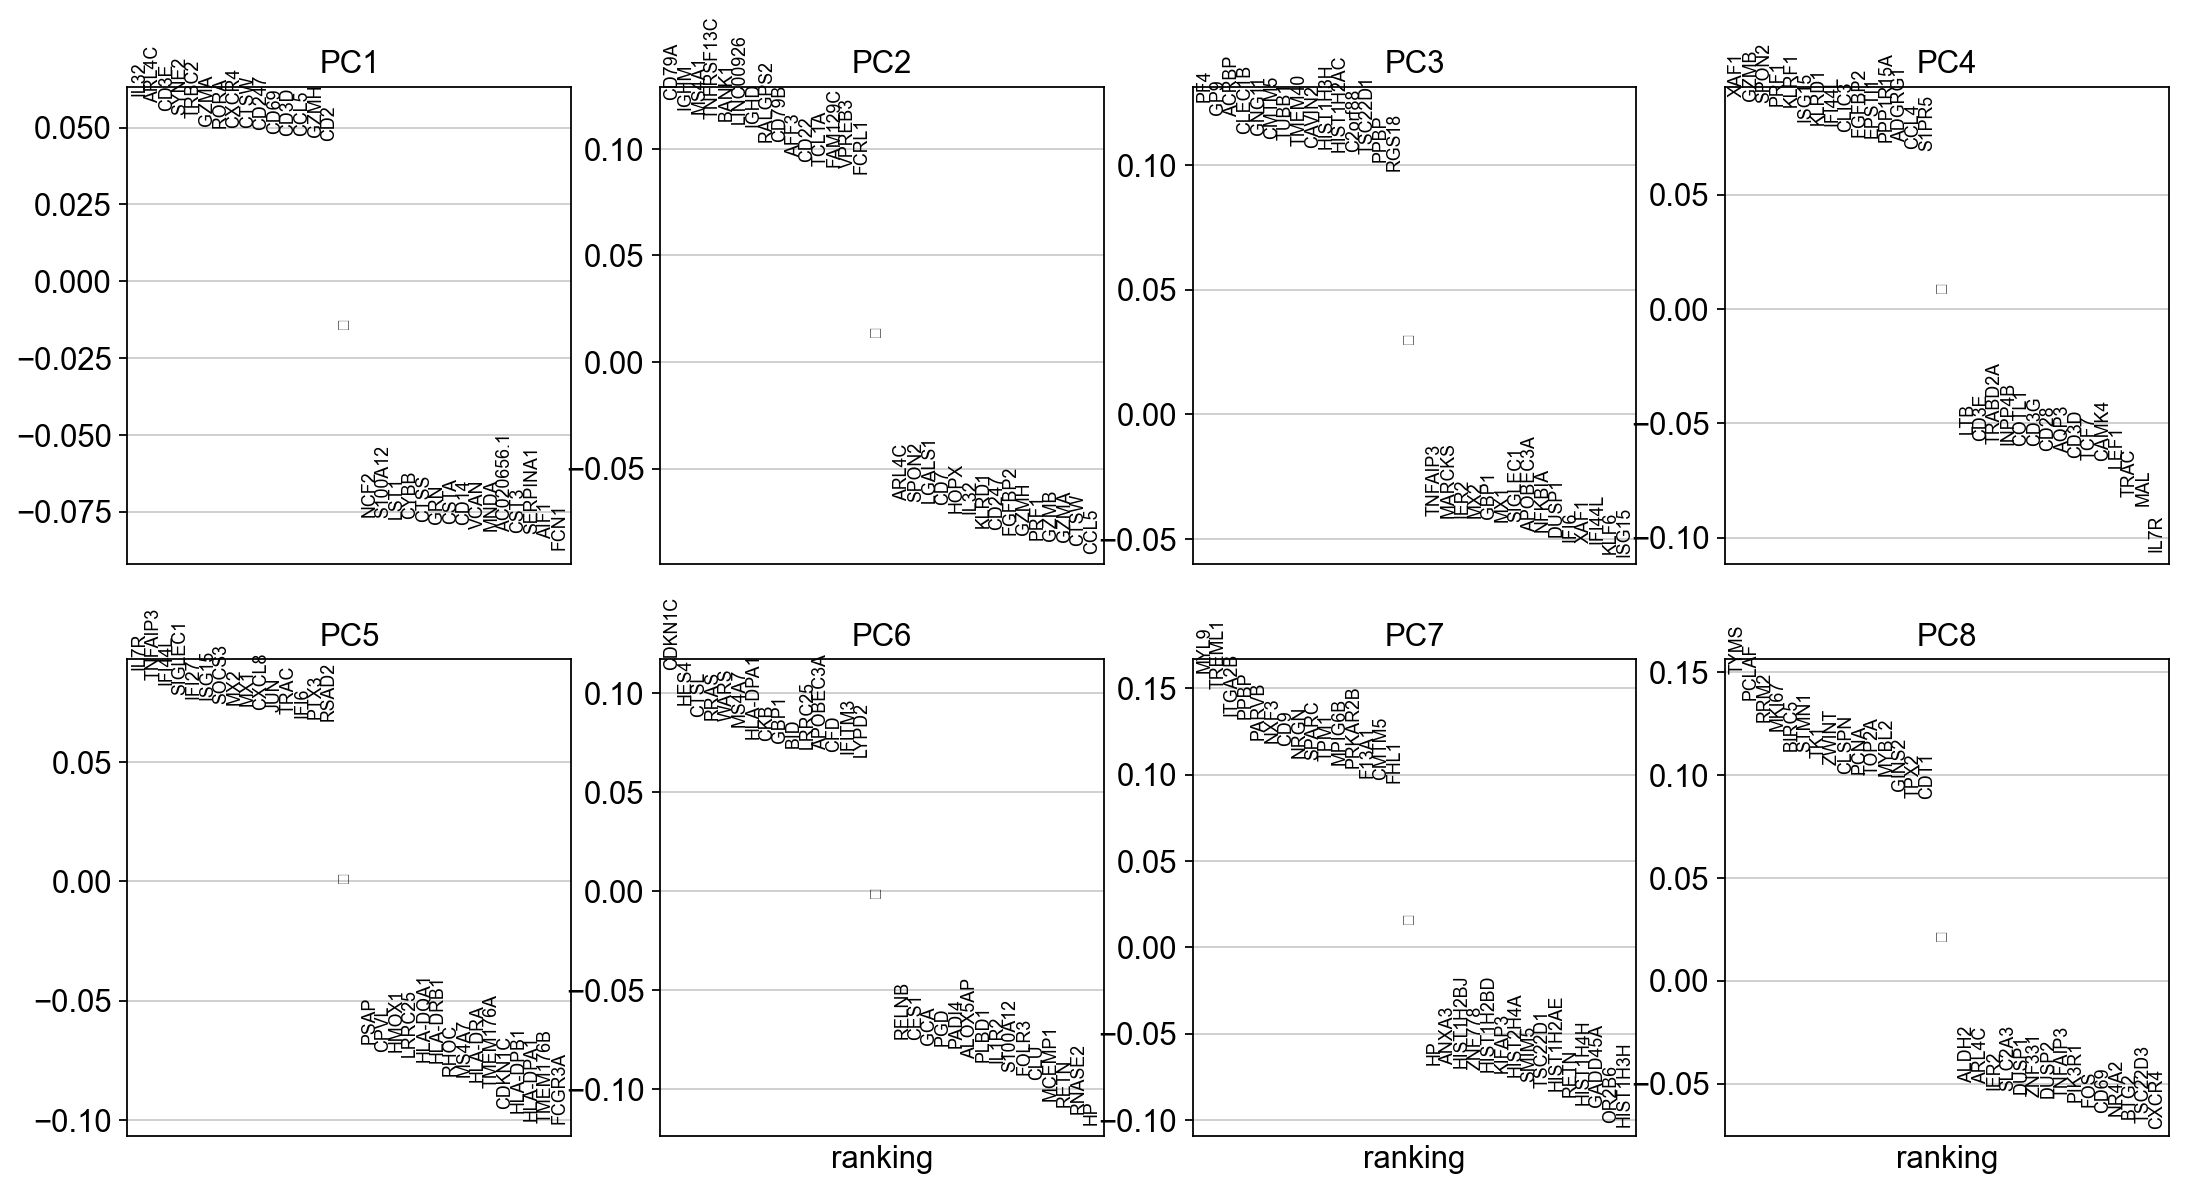

In [11]:
# plot loading
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6,7,8])

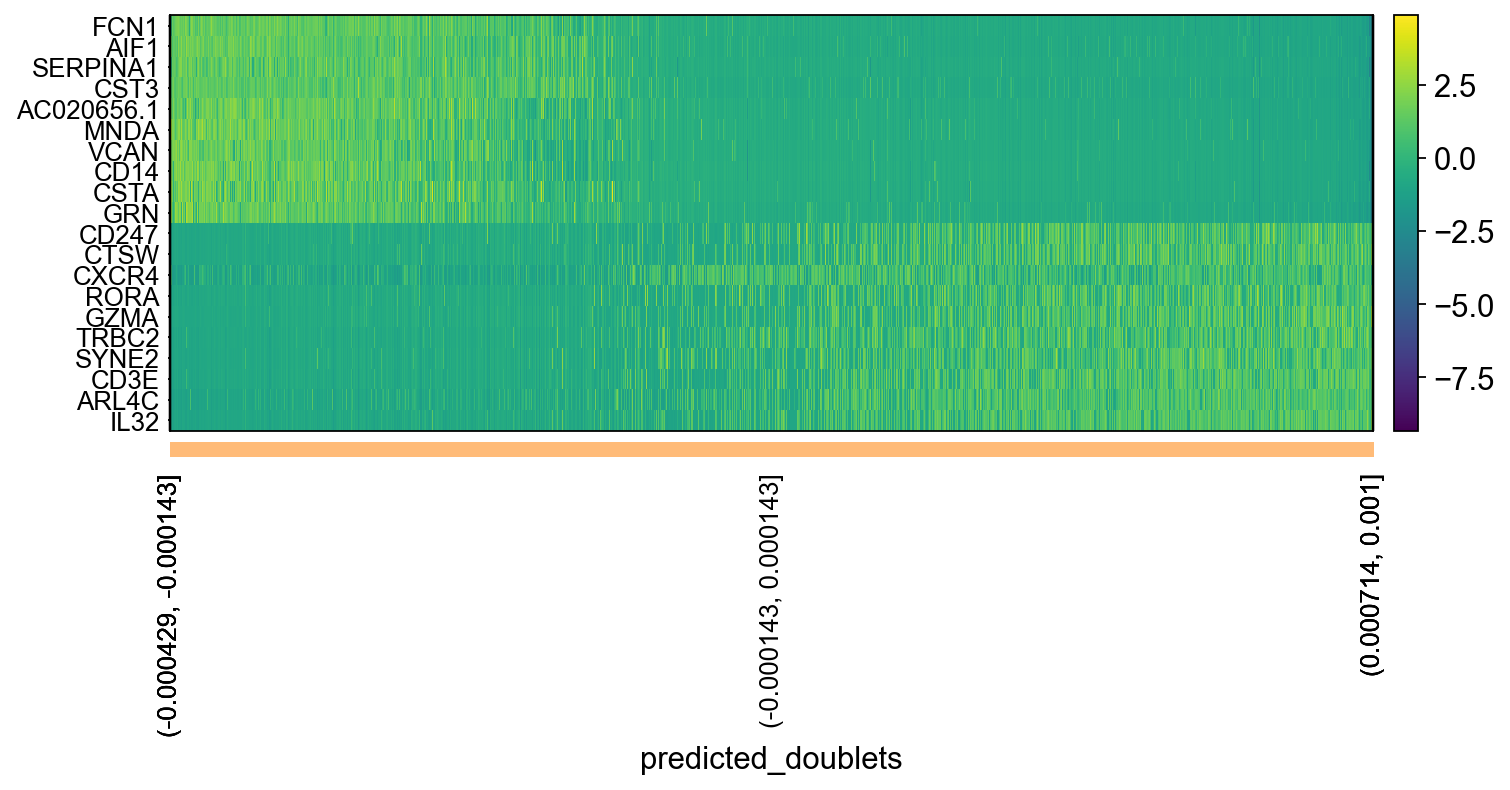

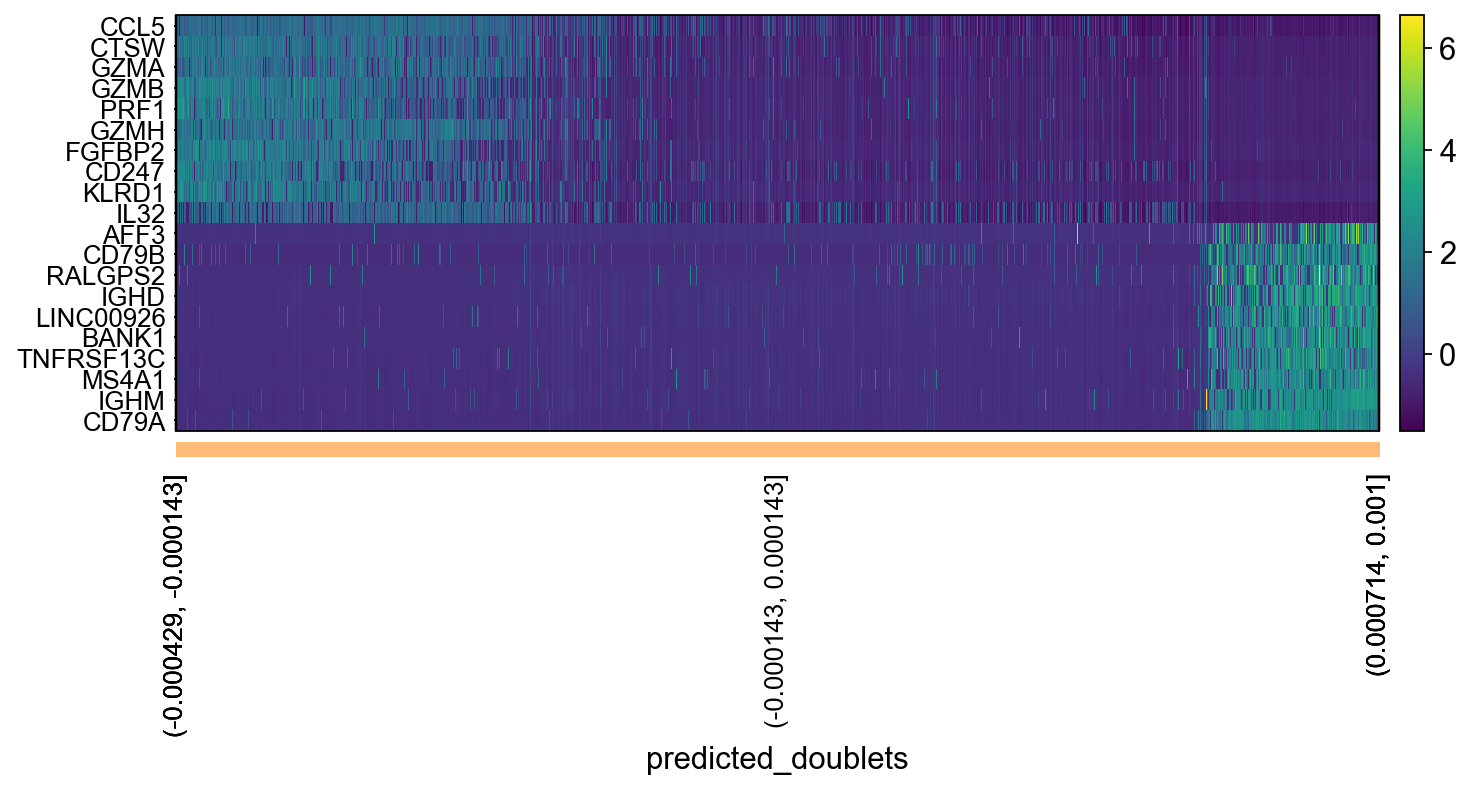

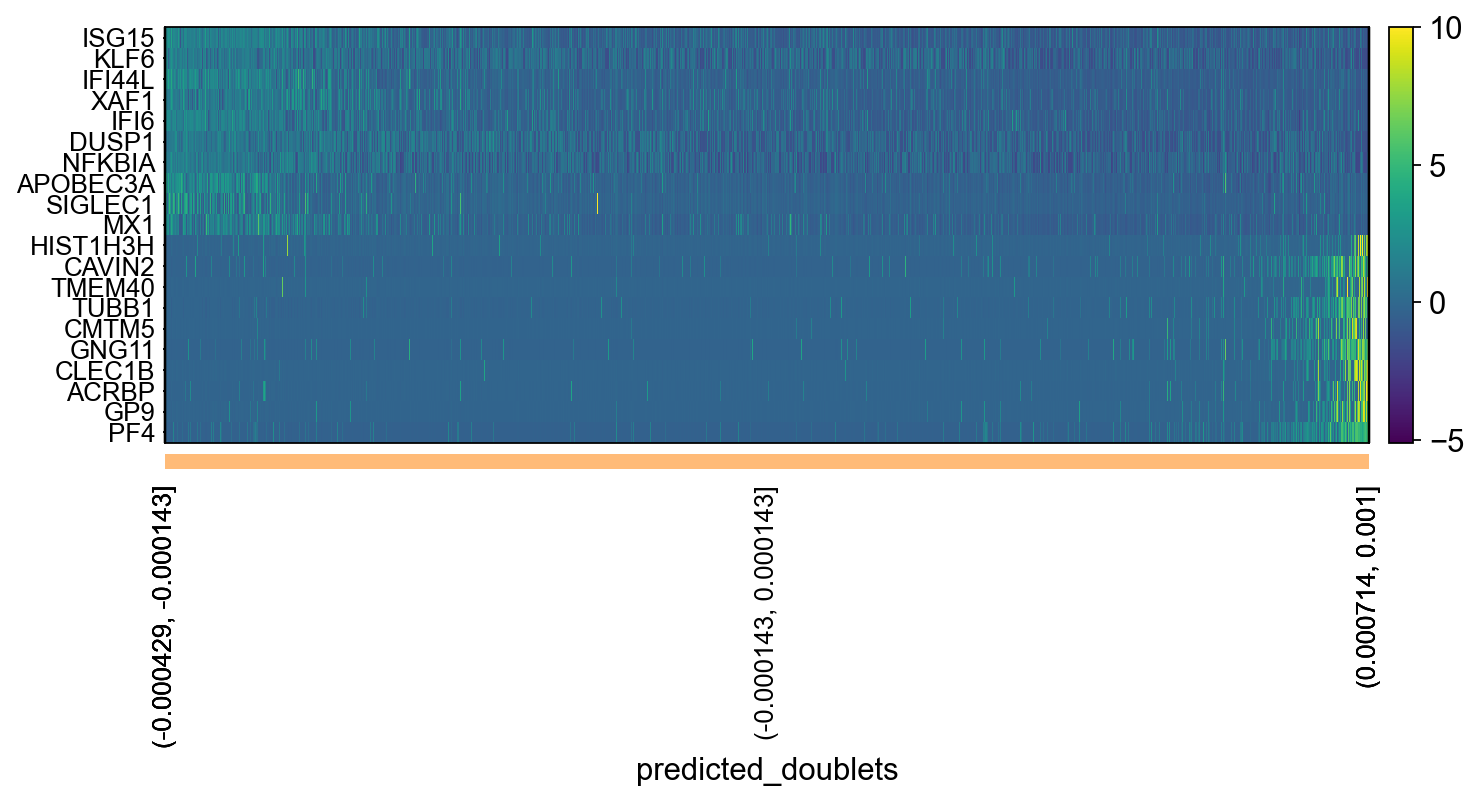

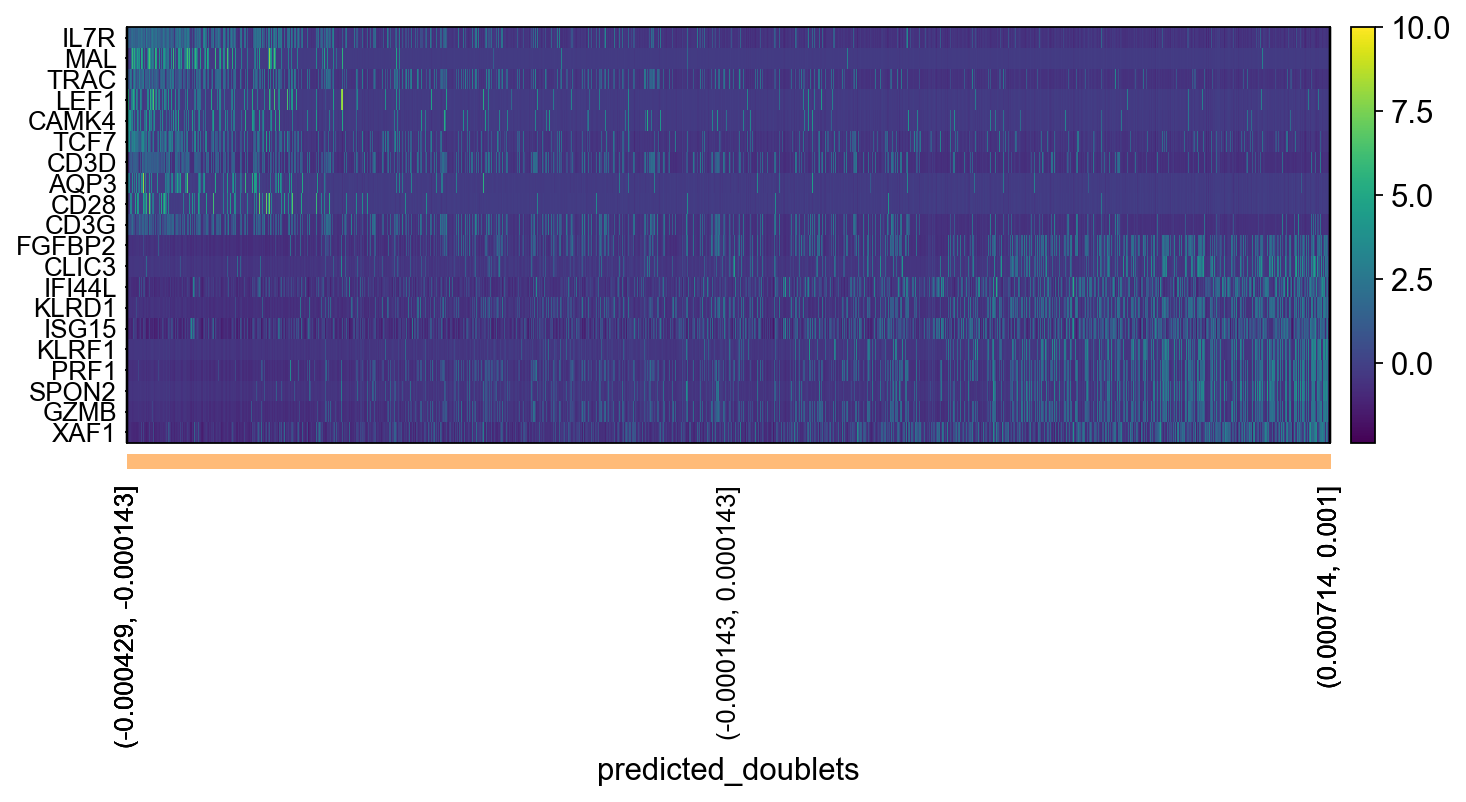

In [12]:
genes = adata.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby='predicted_doublets', swap_axes = True, use_raw=False)

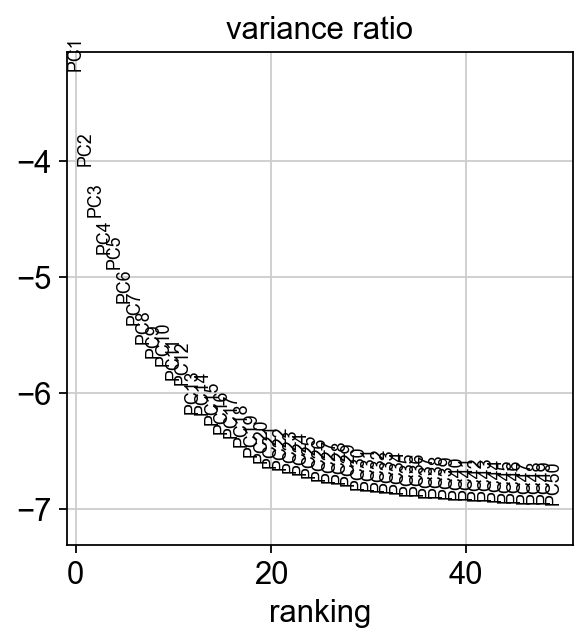

In [13]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

### 3.tSNE

In [14]:
sc.tl.tsne(adata, n_pcs = 30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:58)


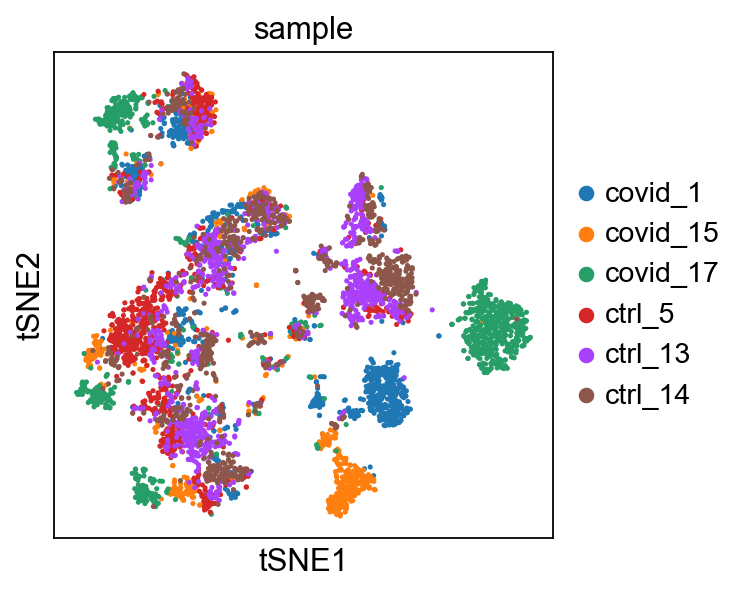

In [15]:
sc.pl.tsne(adata, color='sample')